<a href="https://colab.research.google.com/github/HugoKD/ML/blob/main/2023_DB_DS_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RB DS exercise

## Problem statement

Our client is a private dental clinic chain with a current network of 71 stores in France. The aim of this project is to understand what drives **center performance** and more precisely identify to what extent it is driven by **internal factors** such as quality of service or by **external factors** such as number of patients in the catchment area.

Therefore our team of consultants and data scientists has gathered **data on the clients' centers** and on the catchment areas surronding these centers. This data is available in the file attached *20231124_dental_center_data.xlsx*.

In order to solve this case please write your code in the cells below each question. Please feel free to add markdown cells to specify your reasoning and comment your code for easier understanding.

**Note: please make sure to use a version of Python > 3.9 and to import all the necessary packages in the cell right below**

In [2]:
# import your packages here
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap


from scipy.stats import skew
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


from sklearn.model_selection import train_test_split,StratifiedKFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error as MSE,make_scorer
import xgboost as xg

In [3]:
# check your python version
!python -V

Python 3.10.12


Goal : The aim of this project is to understand what drives center performance and more precisely identify to what extent it is driven by internal factors such as quality of service or by external factors such as number of patients in the catchment area. <br>

Notes :

*   Que des variables quantitatives (int/float)
*   Ce n'est pas un probleme de regression ou de classification classique, on veut à la fois maximiser le revenue tout en assurant une marge conséquente
*   Pas beaucoup de données -> peu de variables dans nos modèles, pas de DL, enlever certaines variables peut être corrélées, Bootstrap Sampling ou CV, faire du feature engineering, data augmentation comme créer l'âge du centreou des ratios, modèles baysiens pour obtenir des incertitudes, stratifier les données, si plusieurs var correlées ne garder que celle qui possède le moins de valeur manquante
*    Avec ce dernier point, cela rend les données manquantes encore importantes -> Soit voir au cas par cas en intuitant un algo soit K-NN pour faire une moyenne avec ses clusters
*    Facteurs internes : revenue, r_margin (indicateurs de performance économique),
fte (effectif du personnel),
nbr_reviews, avg_rating (qualité perçue),
rent (coût de l’emplacement),
et l'Opening year (ancienneté)
*   Facteurs Externes : nbr_patients, patients_yearly_growth, patients_over_65,
median_revenue, r_unemployment, r_poverty (situation socio-économique),
ainsi que les densités
*   Les performances du cabinet pourront être expliquées par à la fois le revenu et r_margin -> Perf = α×log(revenue + jitter)+(1−α)×r_margin, α à adapter selon les objectifs du dentiste
*   Identifier quelles sont les variables qui sont importantes -> SHAP




## Question 1

Inspect the data in the *20231124_dental_center_data.xlsx* file and **perform a descriptive data analysis**. Sample questions could be:
- Are there missing values?
- Are there outliers or unexpected values?
- Which variables are correlated, to what extend?
- ...

**Note: do not hesitate to use data vizualisation to support your findings**

- Some missing values -> K NN
- some unexepcted values (density negative, id 9), sinon some outliers mais pas problématiques, voir avec le
- density are correlated -> PCA
- Globalement des variables asser symetriques et homogenes
- quelques features asser skewed positivement : les taux poverty,  unemployment, patients over 65, revenue and median_revenue ->  transformation logarithmique ou Box-Cox

In [4]:
pd.read_excel('20231124_dental_center_data 1.xlsx').columns

Index(['ID', 'Latitude', 'Longitude', 'Revenue [21; EUR m]',
       'Margin rate [21; %]', 'Dentist FTE [#]',
       'Number of reviews on Google [#]', 'Average Google rating',
       'Rent in the area [EUR/sqm]', 'Patients in the catchment area [#]',
       'Patients' yearly growth in the catchment area [%]',
       'Share of patients in the catchment area over 65 [%]',
       'Median revenue in catchment area [EUR]',
       'Unemployment rate in the catchment area [%]',
       'Poverty rate in the catchment area [%]',
       'Density of doctors in the catchment area [#/100k patients]',
       'Density of pharmacists in the catchment area [ #/100k patients]',
       'Density of dentists in the catchment area [#/100k]', 'Opening year'],
      dtype='object')

In [5]:
# your code here
data = pd.read_excel('20231124_dental_center_data 1.xlsx').drop('ID', axis = 1)
# Densist FTE = full-time equivalent
columns_mapping = {
    'Dentist FTE [#]': 'fte',
    'Margin rate [21; %]': 'r_margin',
    'Revenue [21; EUR m]': 'revenue',
    'Number of reviews on Google [#]': 'nbr_reviews',
    'Average Google rating': 'avg_rating',
    'Rent in the area [EUR/sqm]': 'rent',
    'Patients in the catchment area [#]': 'nbr_patients',
    'Share of patients in the catchment area over 65 [%]': 'patients_over_65',
    'Unemployment rate in the catchment area [%]': 'r_unemployment',
    'Median revenue in catchment area [EUR]': 'median_revenue',
    'Poverty rate in the catchment area [%]': 'r_poverty',
    'Patients\' yearly growth in the catchment area [%]': 'patients_yearly_growth',
    'Density of doctors in the catchment area [#/100k patients]': 'density_doctors',
    'Density of pharmacists in the catchment area [ #/100k patients]': 'density_pharmacists',
    'Density of dentists in the catchment area [#/100k]': 'density_dentists'
}

data = data.rename(columns=columns_mapping)

data.head()

,Latitude,Longitude,revenue,r_margin,fte,nbr_reviews,avg_rating,rent,nbr_patients,patients_yearly_growth,patients_over_65,median_revenue,r_unemployment,r_poverty,density_doctors,density_pharmacists,density_dentists,Opening year
0,48.804336,2.420931,2.4,0.18,7.0,190.0,3.552632,5731,58874.899010,-0.24,13.060859,23330.857143,7.8,13.615055,133.0,66,104,2019
1,49.895083,2.298487,2.6,0.21,9.0,153.0,4.039216,2708,39687.660222,0.18,13.514219,19647.037037,9.6,20.113324,173.0,33,121,2019
2,43.578549,7.119384,3.3,0.21,10.0,163.0,4.288344,4751,25370.677794,-0.68,33.162485,22524.666667,12.5,15.142544,177.0,69,112,2018
3,43.655764,1.370467,2.2,0.09,10.0,145.0,4.158621,3205,6945.136108,1.83,10.971403,23213.333333,8.1,8.124205,179.0,89,116,2020
4,44.879637,-0.570372,2.9,0.21,8.0,63.0,4.650794,3707,6992.074760,1.08,9.078928,19480.000000,7.4,30.930467,182.0,76,121,2019


In [342]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Latitude                71 non-null     float64
 1   Longitude               71 non-null     float64
 2   revenue                 66 non-null     float64
 3   r_margin                66 non-null     float64
 4   fte                     66 non-null     float64
 5   nbr_reviews             68 non-null     float64
 6   avg_rating              68 non-null     float64
 7   rent                    71 non-null     int64  
 8   nbr_patients            70 non-null     float64
 9   patients_yearly_growth  71 non-null     float64
 10  patients_over_65        71 non-null     float64
 11  median_revenue          71 non-null     float64
 12  r_unemployment          70 non-null     float64
 13  r_poverty               70 non-null     float64
 14  density_doctors         69 non-null     floa

In [343]:
print(data.isna().sum()/len(data)*100) #bcp de null relativement à la taille du data set

Latitude                  0.000000
Longitude                 0.000000
revenue                   7.042254
r_margin                  7.042254
fte                       7.042254
nbr_reviews               4.225352
avg_rating                4.225352
rent                      0.000000
nbr_patients              1.408451
patients_yearly_growth    0.000000
patients_over_65          0.000000
median_revenue            0.000000
r_unemployment            1.408451
r_poverty                 1.408451
density_doctors           2.816901
density_pharmacists       0.000000
density_dentists          0.000000
Opening year              0.000000
dtype: float64


In [344]:
negative_values = (data < 0).sum()
print(negative_values) #valeur aberrante pour density

Latitude                   0
Longitude                  6
revenue                    0
r_margin                   4
fte                        0
nbr_reviews                0
avg_rating                 0
rent                       0
nbr_patients               0
patients_yearly_growth    34
patients_over_65           0
median_revenue             0
r_unemployment             0
r_poverty                  0
density_doctors            1
density_pharmacists        0
density_dentists           0
Opening year               0
dtype: int64


In [345]:
nan_revenue = data[data['revenue'].isna()]

In [346]:
nan_revenue

,Latitude,Longitude,revenue,r_margin,fte,nbr_reviews,avg_rating,rent,nbr_patients,patients_yearly_growth,patients_over_65,median_revenue,r_unemployment,r_poverty,density_doctors,density_pharmacists,density_dentists,Opening year
17,48.736834,1.365297,NaN,NaN,NaN,19.0,4.578947,1590,16206.342013,-0.46,15.763840,17016.923077,7.2,24.174403,106.0,40,104,2016
20,49.023062,1.148888,NaN,NaN,NaN,10.0,4.700000,1844,17408.129904,-1.24,19.890533,18980.000000,8.1,15.407340,96.0,34,109,2019
29,48.959236,2.882169,NaN,NaN,NaN,33.0,4.060606,2870,23423.885548,0.61,13.688214,19556.153846,7.4,13.890370,100.0,44,78,2016
34,48.692024,6.181425,NaN,NaN,NaN,14.0,4.714286,2559,52741.353401,0.16,13.566230,21786.206897,7.8,17.647573,176.0,73,120,2018
37,43.838278,4.363345,NaN,NaN,NaN,NaN,NaN,1988,55887.755483,-0.12,21.732715,18604.666667,11.0,25.542045,150.0,72,114,2021


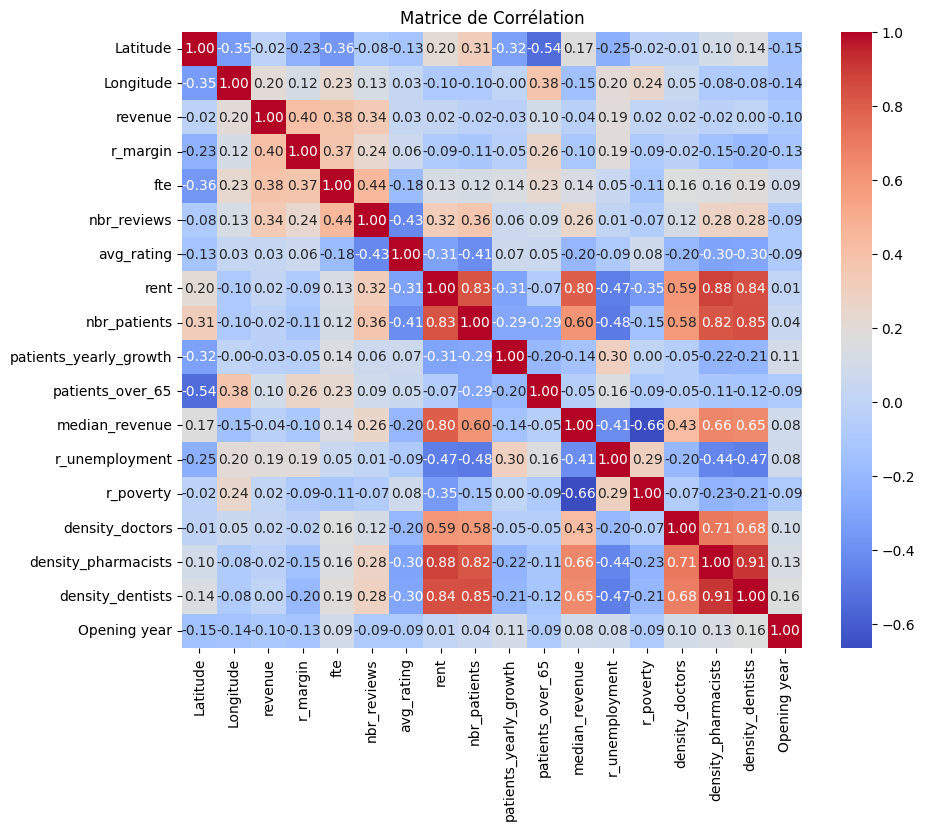

In [347]:
# Correlation forte entre les densities -> PCA
plt.figure(figsize=(10, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matrice de Corrélation')
plt.show()

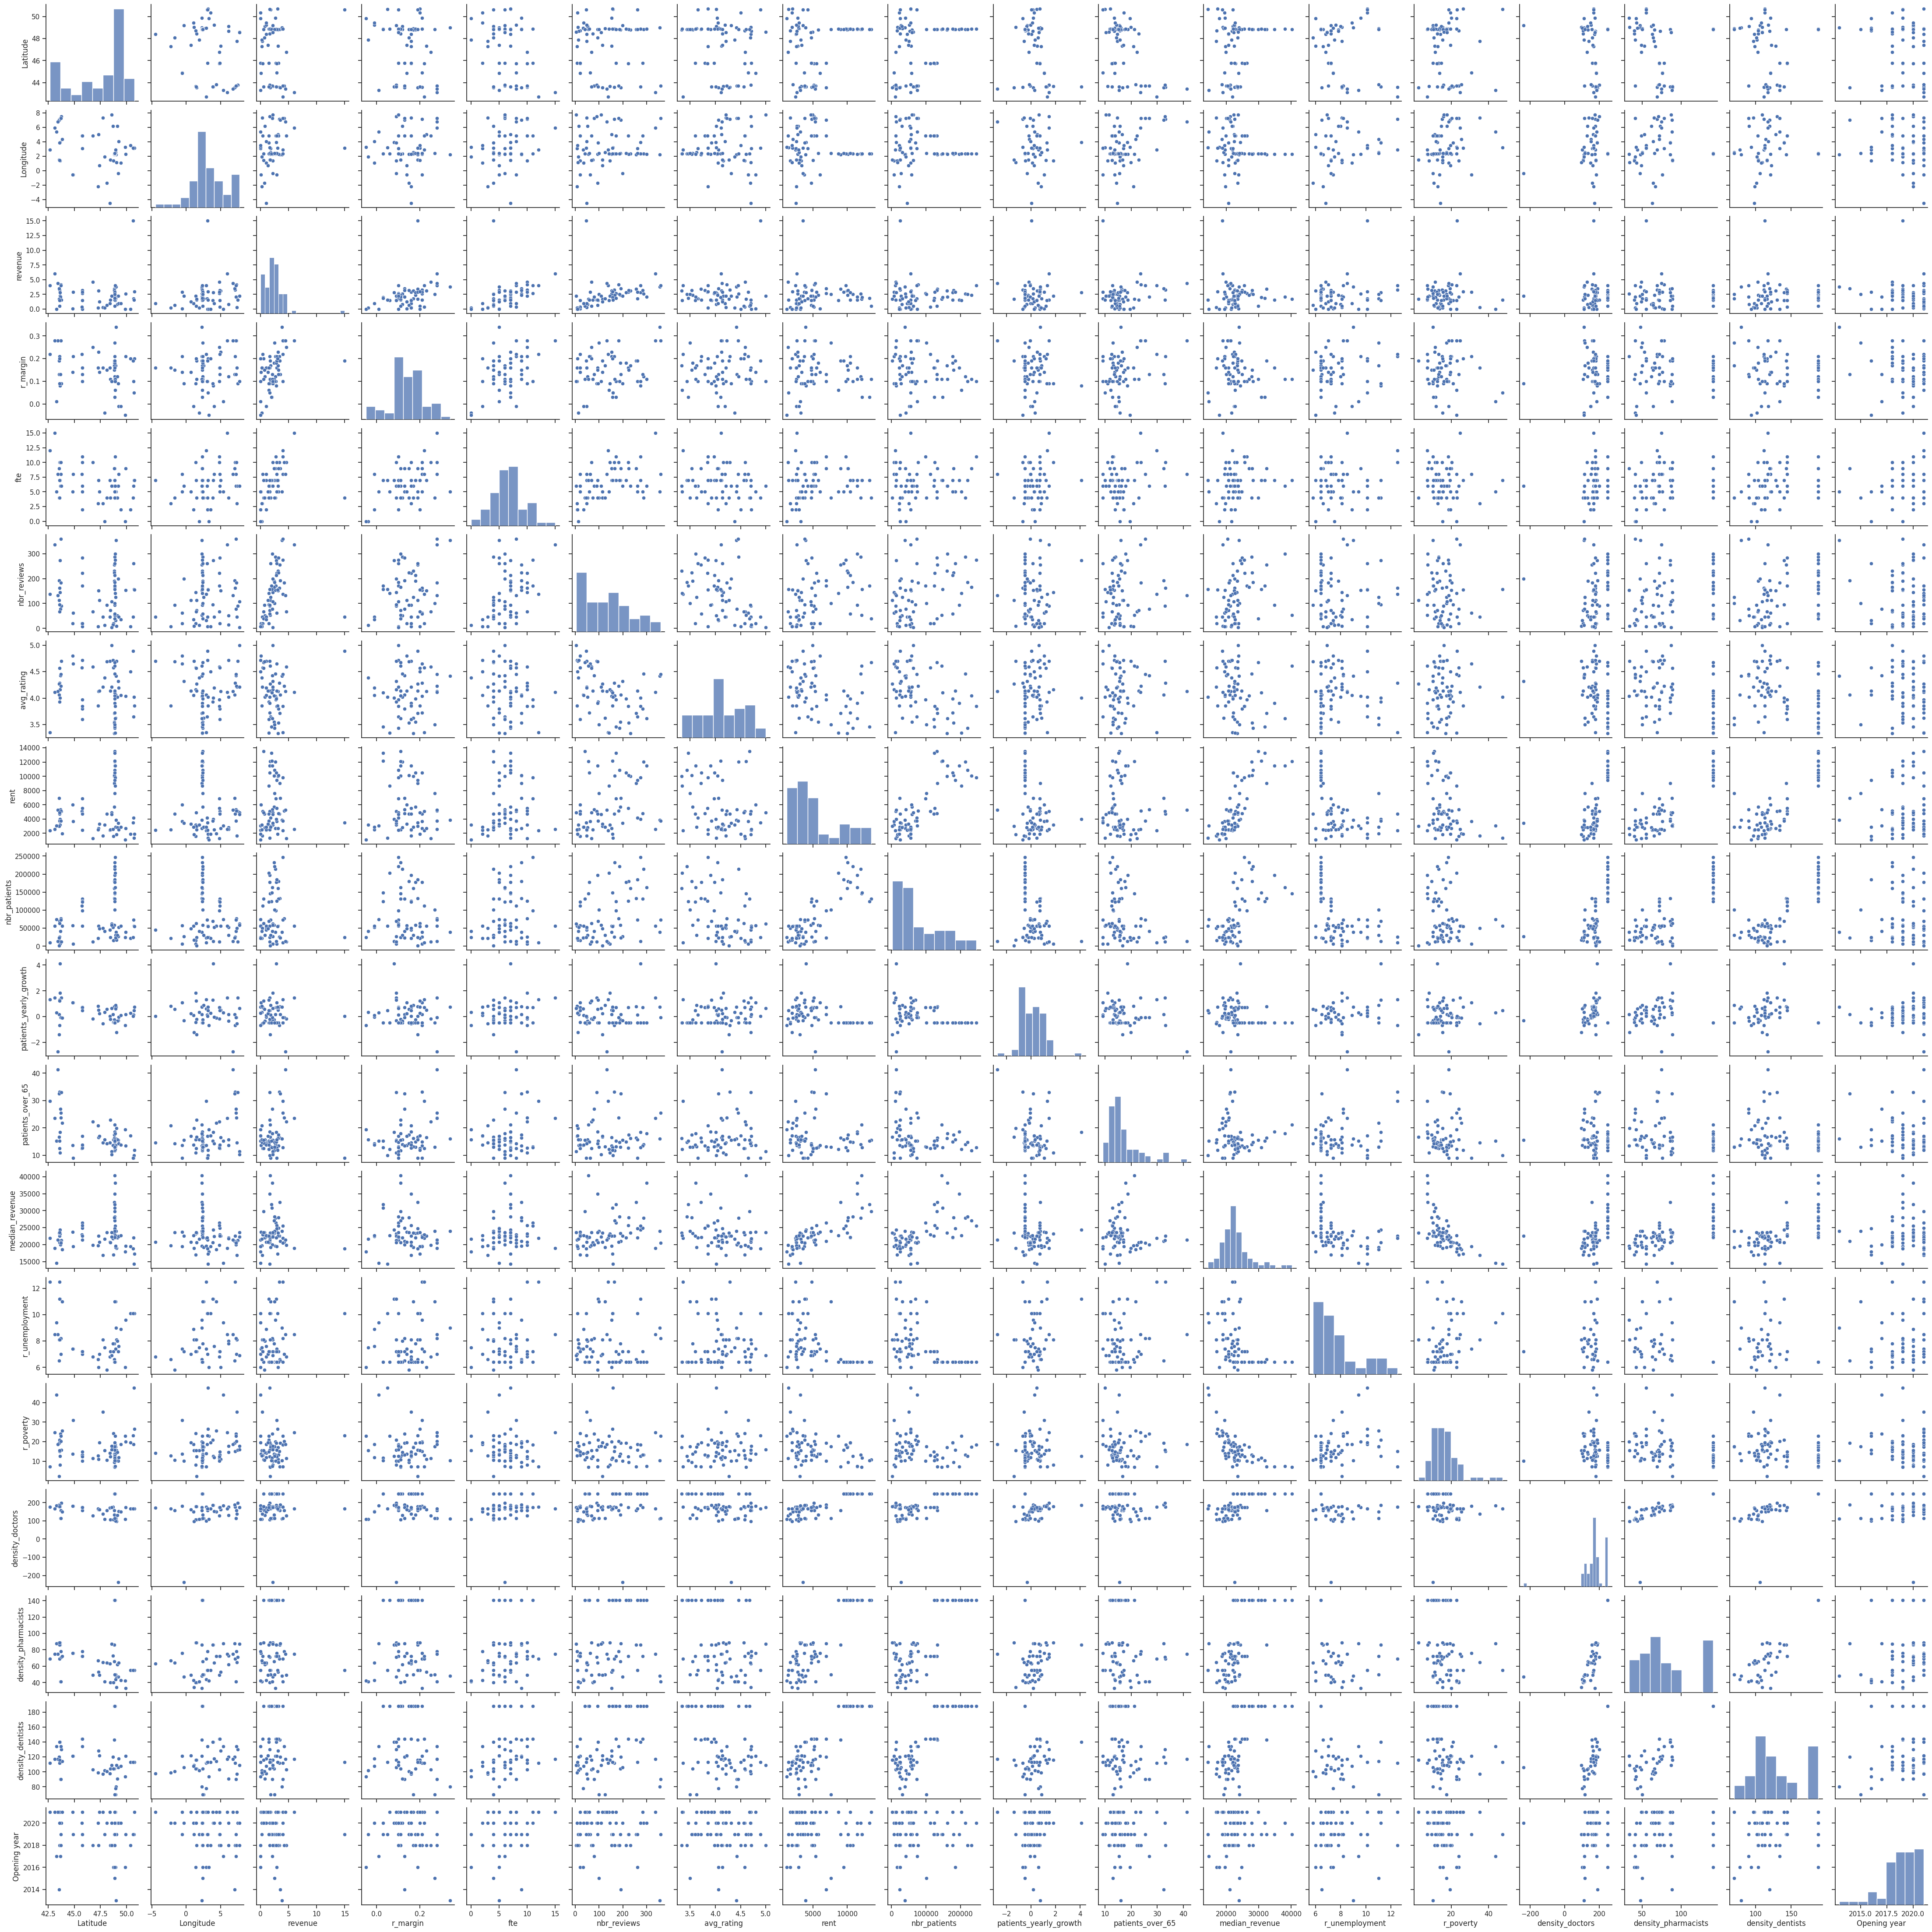

In [7]:
sns.set_theme(style="ticks")
sns.pairplot(data)

On voit bien ici une relation quasi linéaire entre plusieurs variables. Par Exemple (rent,median revenue),(fte, revnue), (revenue, r_margin) ...

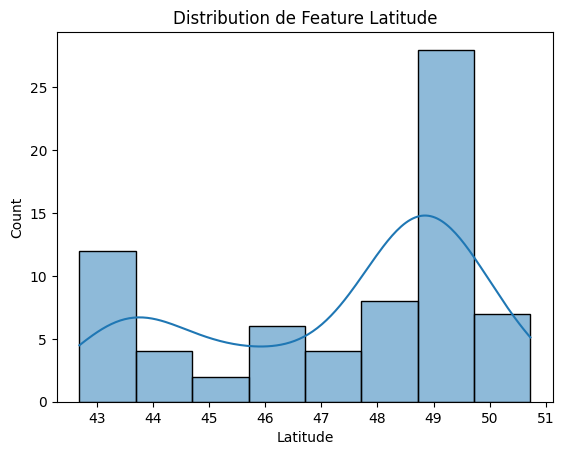

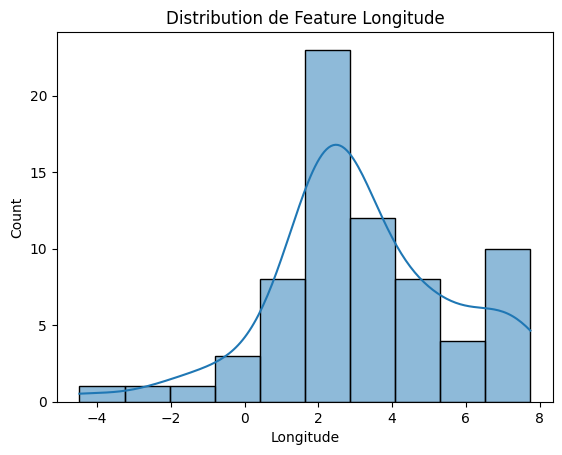

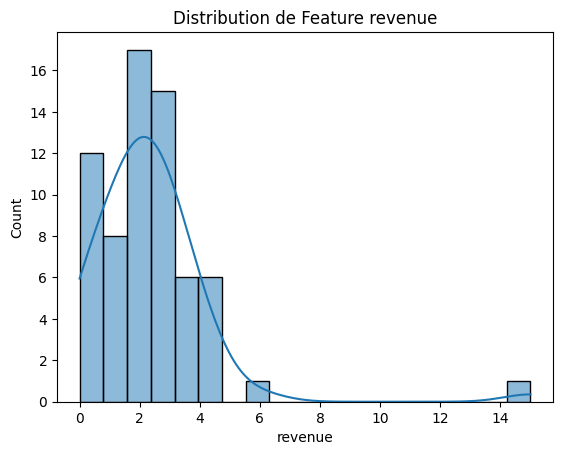

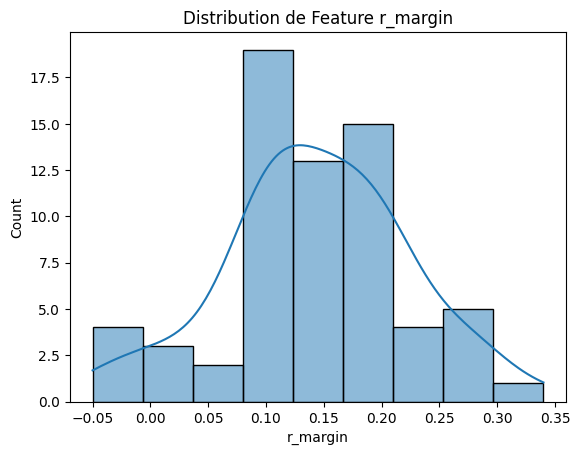

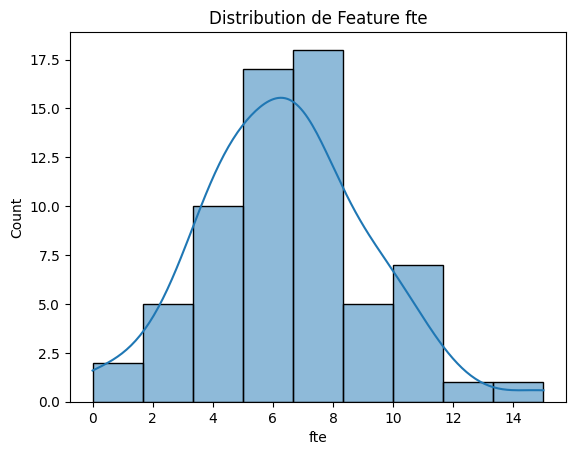

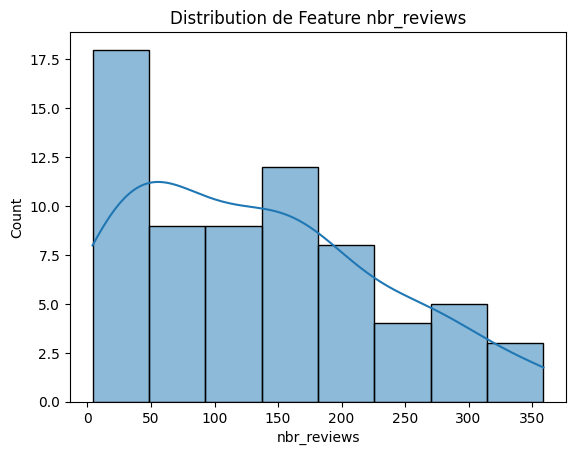

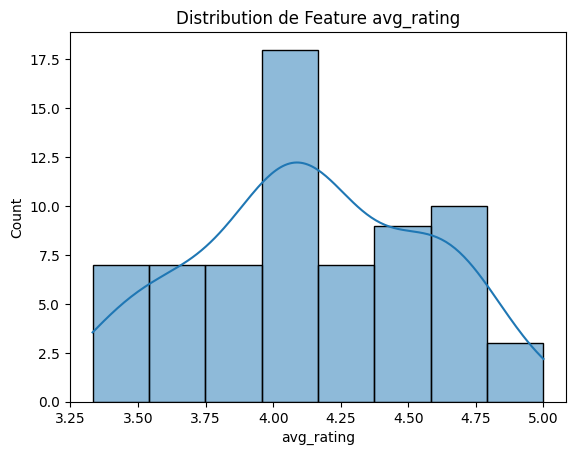

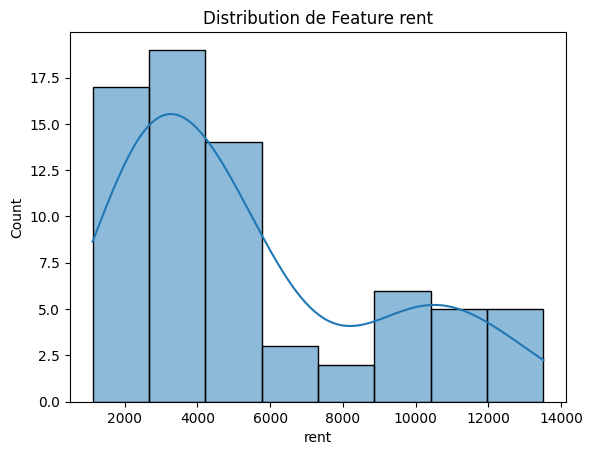

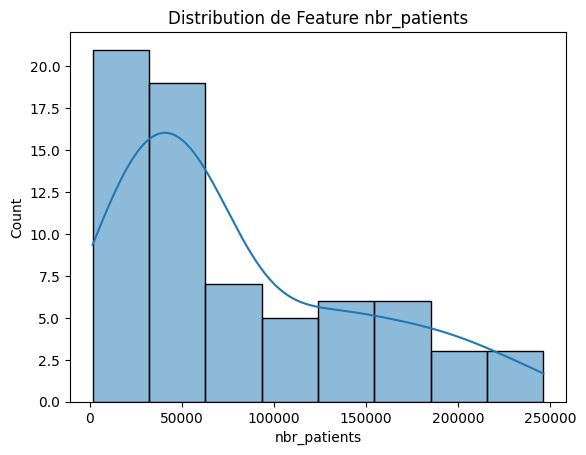

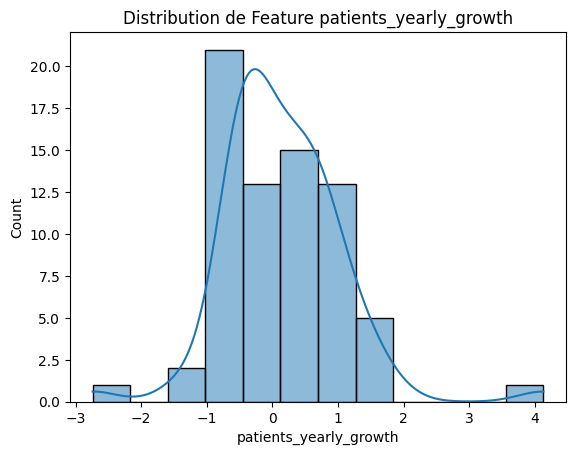

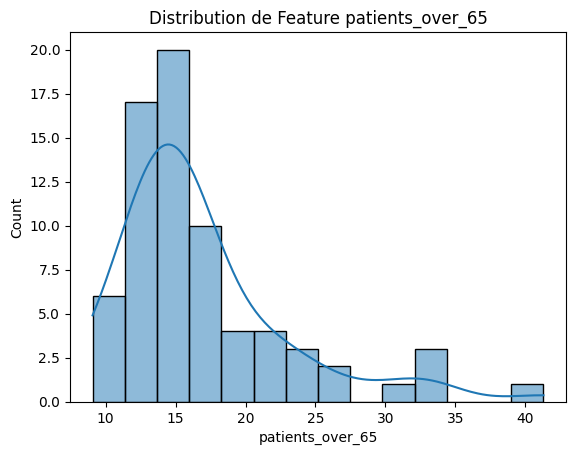

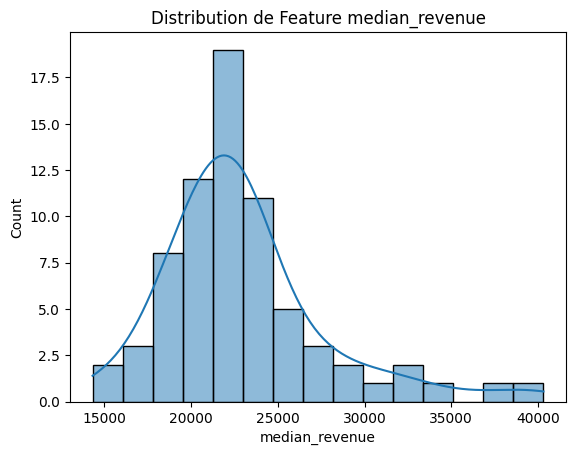

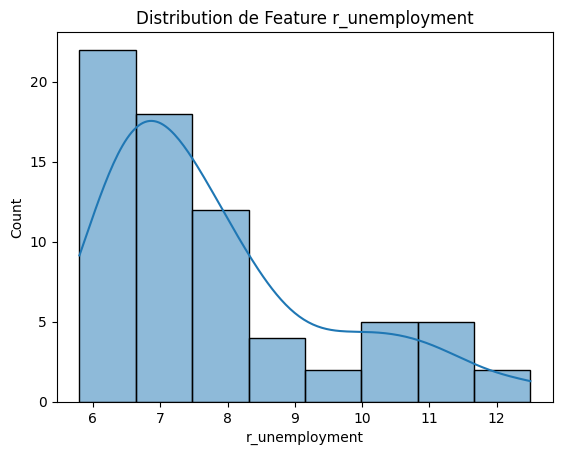

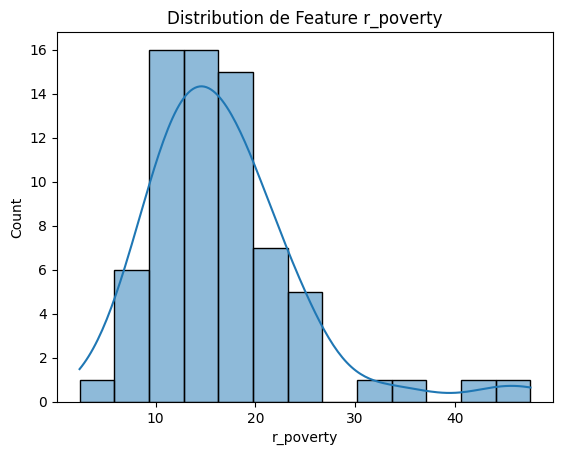

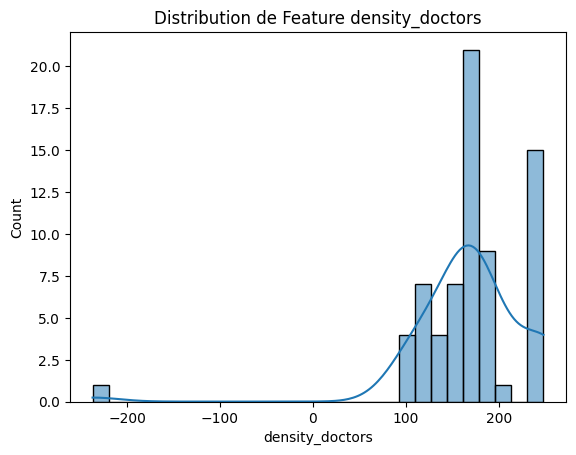

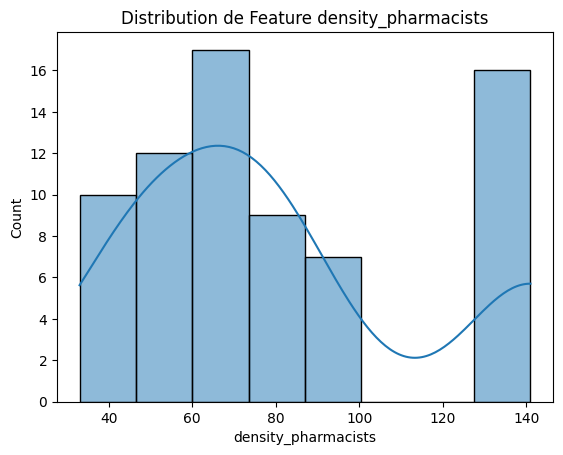

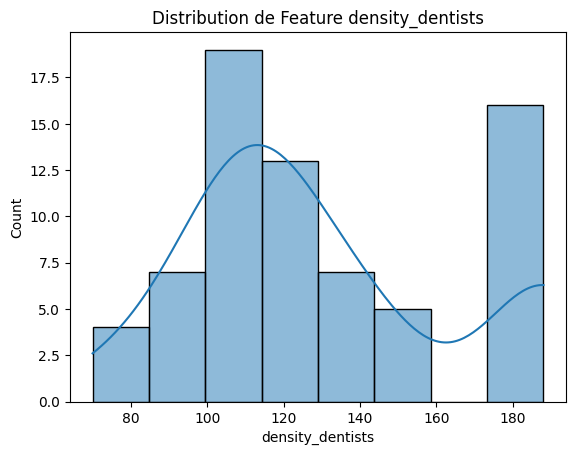

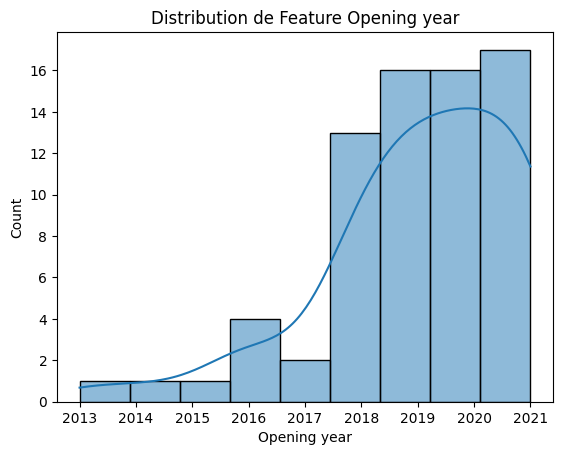

In [348]:
#Outlier dans revenue (14,6), patiens yearly growth, doctors in the catchment area
for c in data.columns:
  sns.histplot(data[c], kde=True)
  plt.title('Distribution de Feature' +' ' + str(c))
  plt.show()

In [413]:
imputer = KNNImputer(n_neighbors=5) # faire quelque chose de plus robuste pour la prochaine fois
data_imputed = imputer.fit_transform(data)
data_without_nan = pd.DataFrame(data_imputed, columns=data.columns)

In [350]:
skewness_stats = data_without_nan.apply(lambda x: skew(x))

# Affichage sous forme de tableau
skewness = pd.DataFrame({
    'Value': skewness_stats
})

skewness

,Value
Latitude,-0.596265
Longitude,-0.167659
revenue,3.761546
r_margin,-0.138074
fte,0.272696
nbr_reviews,0.558581
avg_rating,-0.062306
rent,0.887607
nbr_patients,0.939250
patients_yearly_growth,0.899073


In [351]:
(data_without_nan[data_without_nan['revenue']> 14])

,Latitude,Longitude,revenue,r_margin,fte,nbr_reviews,avg_rating,rent,nbr_patients,patients_yearly_growth,patients_over_65,median_revenue,r_unemployment,r_poverty,density_doctors,density_pharmacists,density_dentists,Opening year
69,50.616725,3.133466,15.0,0.19,4.0,46.0,4.891304,3484.0,24675.533216,0.04,9.05954,18853.333333,10.1,23.194949,166.0,55.0,113.0,2019.0


In [352]:
data_without_nan[["Opening year"]].describe()

,Opening year
count,71.000000
mean,2019.084507
std,1.762680
min,2013.000000
25%,2018.000000
50%,2019.000000
75%,2020.000000
max,2021.000000


#### Discussion sur la target à choisir

Différentes stratégie en fonction de l'objectif du cabinet :
- Si son objectif c'est le profit du centre : margin*revenue
- profit per dentist full-time equivalent : m*r/fte
- profitability adjusted for key operating costs : r*m /( FTE+Rent)
- Operational efficiency : margin
...
For the sake of thise mission We have choosen two type of objectives : profit per dentist, understanding that dental cabinet have a flat hierarchy, where every dentist has a share of it. And the absolute margin, optimizing the efficiency of the cabinet  

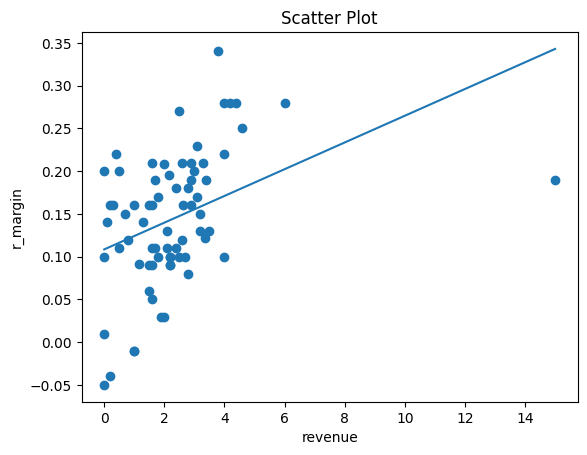

In [414]:
## Scatter entre revenue et r_margin
plt.scatter(data_without_nan['revenue'], data_without_nan['r_margin'])
plt.plot(np.unique(data_without_nan['revenue']), np.poly1d(np.polyfit(data_without_nan['revenue'], data_without_nan['r_margin'], 1))(np.unique(data_without_nan['revenue'])))
plt.xlabel('revenue')
plt.ylabel('r_margin')
plt.title('Scatter Plot')
plt.show()

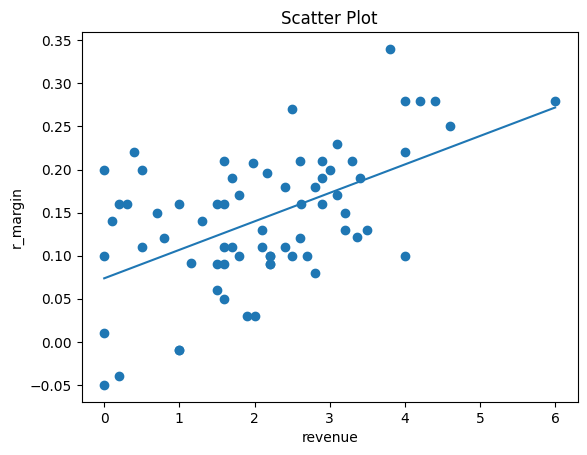

In [415]:
## Scatter entre revenue et r_margin
plt.scatter(data_without_nan['revenue'].drop(69), data_without_nan['r_margin'].drop(69))
plt.plot(np.unique(data_without_nan['revenue'].drop(69)), np.poly1d(np.polyfit(data_without_nan['revenue'].drop(69), data_without_nan['r_margin'].drop(69), 1))(np.unique(data_without_nan['revenue'].drop(69))))
plt.xlabel('revenue')
plt.ylabel('r_margin')
plt.title('Scatter Plot')
plt.show()

<Axes: xlabel='revenue', ylabel='Count'>

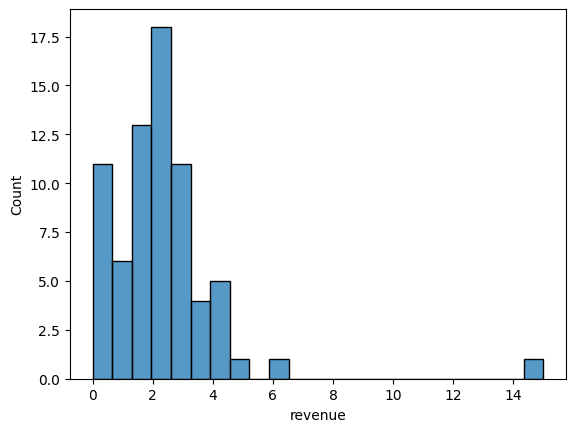

In [356]:
sns.histplot(data_without_nan['revenue'])

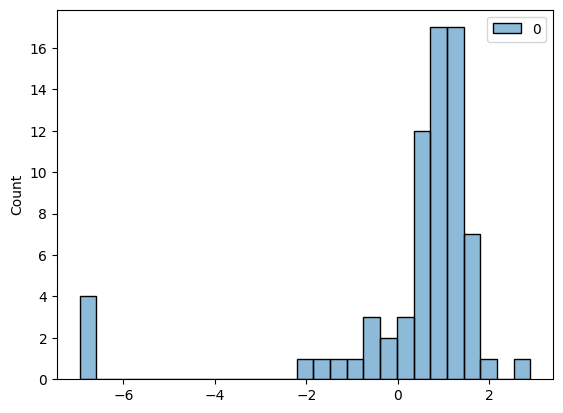

In [357]:
sns.histplot(pd.DataFrame(np.log(data_without_nan['revenue']+ 1e-3)+ data_without_nan['r_margin']))
plt.show()

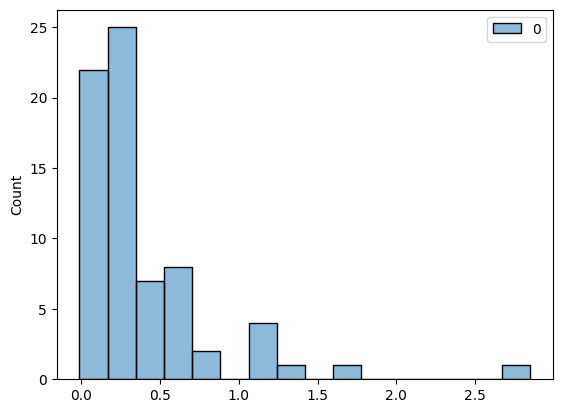

In [358]:
sns.histplot(pd.DataFrame(data_without_nan['revenue'] * data_without_nan['r_margin']))
plt.show()

In [ ]:
#seaborn voir la relation
#augmenter les données
#séparer
## Corre entre target et
## Voir si revenue = Nan <=> revnue = 0 cf data creation

## Question 2

Which variables **explain the largest share of center performance?** Are they rather linked to operational center performance or to the center's catchment area? Please try to **build a small supervised machine learning model** to support your findings.

- We've decided to create the target revenue * r_margin as the variable to represente center performance.

###Prepo

In [359]:
operational_features = ['revenue', 'r_margin' 'fte', 'nbr_reviews', 'avg_rating','nbr_patients','Opening year']
catchment_features = [
    'rent','patients_yearly_growth','patients_over_65','median_revenue',
    'r_unemployment','r_poverty','density_doctors','density_pharmacists','density_dentists'
]

In [360]:
## Missing values : KNNImputer
imputer = KNNImputer(n_neighbors=5)
data_imputed = imputer.fit_transform(data)
data_transform = pd.DataFrame(data_imputed, columns=data.columns)

In [361]:
## Parce qu'on a peu de données on va quand meme faire une pca sur density

data_pca = data_transform[["density_pharmacists", "density_doctors",
"density_dentists"]]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_pca)

pca = PCA(n_components=1)
data_with_pca = pca.fit_transform(data_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
data_transform['density'] = data_with_pca
data_transform = data_transform.drop(data_pca.columns,axis = 1)

Très mauvaise idée d'utiliser un clip ou un transformation des données sur si peu de données, et sur une fraction qui peut représenter 8% du dataset. Donc plutôt que d'utiliser un log transformation ou un box cox, voir d'autre transformation et sinon ne pas en utiliser.

In [363]:
## 1er jet : Box cox des features :
box_cox_columns = skewness[skewness['Value'] > 1].index
for column in box_cox_columns:
    data_transform[column] = stats.yeojohnson(data_transform[column])[0]

#### Modification des features :

- Duration ok
- Latitude et longitude ne traduisent aucune données utilisable pour le modèle .. Plus intéressant obtenir la distance à l'hyper centre en utilisant la formule de Haversine, ou d'autre informations dérivées

In [364]:
##Feature engineering :
##Traduire la notion de durée plus que de data -> plus utile pour le modèle !
##tps_creation = 2021 - Opening year

data_transform['duration'] = 2021 - data_transform['Opening year']
data_transform['duration'].describe()
data_transform = data_transform.drop('Opening year', axis = 1)

In [ ]:
## Pour l'instant  suppresion de la feature longitude/lattitude

In [411]:
data_transform = data_transform.drop(['Latitude', 'Longitude'], axis = 1)

#### Création de la target

In [365]:
data_transform['target'] = data_transform['revenue'] * data_transform['r_margin']

In [366]:
## To stratify our data, bec we don t have much data
data_transform['stratify'] = pd.qcut(data_transform['target'], q=5, labels=False)

In [367]:
## To stratify our data, bec we don t have much data

y = data_transform[['target','stratify']]
X = data_transform.drop(['target','revenue','r_margin','stratify'], axis = 1)

In [368]:
## Est ce que l'on a besoin de normaliser ?

<Axes: xlabel='fte', ylabel='revenue'>

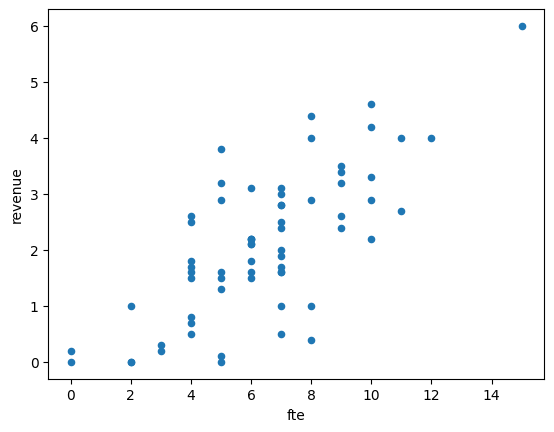

In [407]:
data['target'] = data['revenue'] * data['r_margin']
data.drop(69).plot.scatter(x='fte', y='revenue')

In [406]:
data.corr()['target'].sort_values()

,target
Opening year,-0.170971
density_pharmacists,-0.158618
density_dentists,-0.151509
median_revenue,-0.148554
nbr_patients,-0.140199
Latitude,-0.120649
rent,-0.108611
patients_yearly_growth,-0.060900
density_doctors,-0.050050
r_poverty,0.052742


In [ ]:
## Faire differentes strategies d objectidfs (marge, r*f/revenue)

###Model built

In [369]:
## Pourquoi squared = False : car elle conserve la même unité que la variable cible et est sensible aux grandes erreurs. + souvent utilisée for reg pb
## Plutôt que de stratifier et s'embêter aller droit au but : ShuffleSplit, on a peu de données donc LeaveOneOut pourrait être une bonne solution

In [384]:
X_train, X_test, y_train, y_test = train_test_split(X, y["target"], test_size=0.2, random_state=42)

In [372]:
'''model = RandomForestRegressor()
scorer = make_scorer(mean_squared_error, squared=False)  # RMSE for evaluation

stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(model, X, y['target'], cv=stratified_kf, scoring=scorer, fit_params={'sample_weight': y['stratify']})

print(f'Cross-validation RMSE scores: {cv_scores}')
print(f'Average cross-validation RMSE: {cv_scores.mean()}')'''

"model = RandomForestRegressor()\nscorer = make_scorer(mean_squared_error, squared=False)  # RMSE for evaluation\n\nstratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n\ncv_scores = cross_val_score(model, X, y['target'], cv=stratified_kf, scoring=scorer, fit_params={'sample_weight': y['stratify']})\n\nprint(f'Cross-validation RMSE scores: {cv_scores}')\nprint(f'Average cross-validation RMSE: {cv_scores.mean()}')"

In [ ]:
## Random Forest regressor

R² score on test set: 0.05
MSE :  0.055949


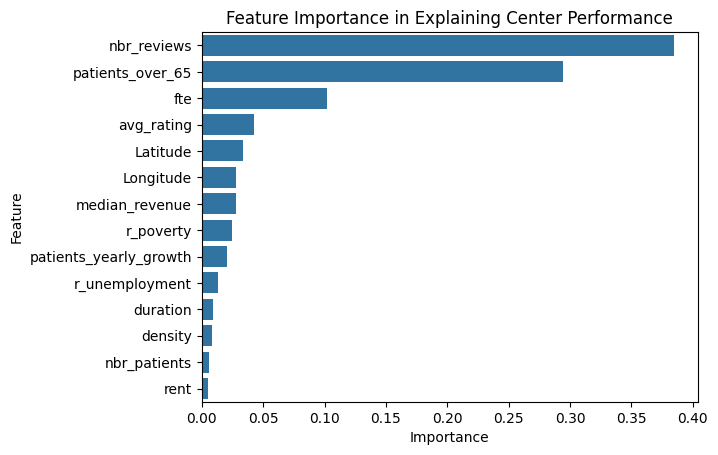

In [391]:
model = RandomForestRegressor(max_depth = 3 ,random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R² score on test set: {r2:.2f}")

mse = (MSE(y_test, y_pred))
print("MSE : % f" %(mse))

feature_importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance in Explaining Center Performance')
plt.show()

In [409]:
import shap

In [410]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.force_plot(explainer.expected_value, shap_values[:, :], X.iloc[:, :])

In [ ]:
## XGBoost regressor

In [395]:
# Train and test set are converted to DMatrix objects,
# as it is required by learning API.
train_dmatrix = xg.DMatrix(data = X_train, label = y_train)
test_dmatrix = xg.DMatrix(data = X_test, label = y_test)

param = {"booster":"gblinear", "objective":"reg:linear"}

xgb_r = xg.train(params = param, dtrain = train_dmatrix, num_boost_round = 10)
pred = xgb_r.predict(test_dmatrix)

mse = (MSE(y_test, pred))
print("RMSE : % f" %(mse))

r2 = r2_score(y_test, pred)
print(f"R² score on test set: {r2:.2f}")

RMSE :  0.040472
R² score on test set: 0.31


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:56:47] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


### Conclusion

In [398]:
print(importance_df)

                   Feature  Importance
3              nbr_reviews    0.384871
8         patients_over_65    0.294341
2                      fte    0.102401
4               avg_rating    0.042659
0                 Latitude    0.033699
1                Longitude    0.028144
9           median_revenue    0.027650
11               r_poverty    0.024507
7   patients_yearly_growth    0.020642
10          r_unemployment    0.012905
13                duration    0.008991
12                 density    0.007996
6             nbr_patients    0.005940
5                     rent    0.005255


C'est bizarre que Latitude et Longitude aient d'aussi grosse influence sur la perf du modele ...

Aurait on pu conclure avant d'utiliser ces modeles ?
Parmis les 10 premières (en terme d'importance) variables, 4 sont internes et 6 externes aux cabinets -> premiere conclusion possible   

In [ ]:
##silouhette

## Question 3

Use an unsupervised learning technique to **cluster the dental centers**. How would you describe each cluster to the client in business terms?

In [ ]:
## utiliser Spectral clustering rather than HDBSCAN

In [ ]:
# your code here

X_3 = pd.concat([data_transform[operational_features], data_transform[catchment_features]], axis = 1)


## Question 4

Let's **enrich our dataset** with additional data on competition. Download the following file providing an overview of all medical institutions in France with their geo coordinates and convert it to a clean dataframe: https://www.data.gouv.fr/fr/datasets/r/98f3161f-79ff-4f16-8f6a-6d571a80fea2.

Perform the necessary **filters to separate dental centers** from the other institutions.

**Reproject the geo coordinates** to the ESPG:4326 coordinate reference system (same as the coordinates in the dental center dataset).

*Hint: to perform operations on coordinates, the libraries shapely, geopandas and pyproj might be helpful*

In [ ]:
# your code here



## Question 5

Let's **assess competitive intensity** around the dental centers. First **draw a circle with a 500 meter radius** around each of the 71 dental center (under the form of a POLYGON). We will refer to these shapes as center catchment areas.
Then, **compute the number of competitors**, i.e. dental centers from the dataset you built in question 4 within each catchment area. Name this variable competitive intensity.

*Hint: to perform operations on coordinates, the libraries shapely, geopandas and pyproj might be helpful*

In [ ]:
# your code here



## Question 6

Now let's **perform the explanatory analysis of question 2 and the clustering of question 3 again**, taking competitive intensity into account. Do the results change, and if so how and why?

In [ ]:
# your code here



## Question 7

**Summarize your findings** in business terms and formulate a recommendation on how to improve the overall dental center network performance based on the answers to the previous questions.

**Note: for this question no code is expected**

In [ ]:
# your awnser

